In [1]:
%matplotlib inline

In [2]:
import sys
sys.path.append("/home/yatindandi/anaconda3/envs/myenv/lib/python3.7/site-packages/gym")
sys.path.append("/data/yatind/anaconda3/lib/python3.7/site-packages (0.10.8)")
import gym
import os
import gc
from lib import plotting
from gym.wrappers import Monitor
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

env = gym.envs.make("Breakout-v0")
device = torch.device("cuda")

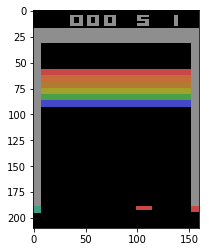

(210, 160, 3)


In [3]:
screen = env.reset()
plt.imshow(screen)
plt.show()
print(screen.shape)

In [4]:
def process(screen):
    screen = screen[34:194,0:160]
    resize = T.Compose([
        T.ToPILImage(),
        T.Grayscale(),
        T.Resize((84,84)),
        T.ToTensor()
    ])
    screen = resize(screen)
    #plt.imshow(screen.numpy()[0], cmap='gray')
    #plt.show()
    screen = np.uint8(screen)
    screen = np.array(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen).float()
    return resize(screen).unsqueeze(0)



In [5]:
screen = process(screen)

In [6]:
screen.shape

torch.Size([1, 1, 84, 84])

In [7]:
class DQN(nn.Module):

    def __init__(self):
        super(DQN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(4, 32, kernel_size=8, stride=4),nn.ReLU(),nn.Conv2d(32, 64, kernel_size=4, stride=2),nn.ReLU(),nn.Conv2d(64, 64, kernel_size=3, stride=1),nn.ReLU()
        )
        
        self.head = nn.Sequential(
            nn.Linear(7*7*64, 512),nn.ReLU(),nn.Linear(512, 4)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0),-1)
        x = self.head(x)
        return x


In [8]:
policy_net = DQN().to(device)
target_net = DQN().to(device)
target_net.load_state_dict(policy_net.state_dict())
optimizer = optim.RMSprop(policy_net.parameters())
Transition = namedtuple("Transition", ["state", "action", "reward", "next_state", "done"])

In [9]:
state = env.reset()
state = process(state)
state = torch.cat(tuple([state] * 4), dim=1)
print(state.shape)

torch.Size([1, 4, 84, 84])


In [10]:
def learn(env,num_episodes,experiment_dir,replay_memory_size=500000,replay_memory_init_size=50000,update_target_estimator_every=10000,discount_factor=0.99,epsilon_start=1.0,epsilon_end=0.1,epsilon_decay_steps=500000,batch_size=32,
record_video_every=50):
    
    replay_memory = []
    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))
    
    #monitor_path = os.path.join(experiment_dir, "monitor")
    
    #if not os.path.exists(monitor_path):
        #os.makedirs(monitor_path)
    
    num_steps = 0
    state = env.reset()
    state = process(state)
    state = torch.cat(tuple([state] * 4), dim=1)
    
    def get_action():
        sample = random.random()
        epsilon = epsilon_end + (epsilon_start - epsilon_end) * math.exp(-1. * num_steps / epsilon_decay_steps)
        if sample > epsilon:
            with torch.no_grad():
                return (policy_net(state.to(device)).max(1)[1].data[0]).to(torch.device("cpu"))
        else:
            return random.randrange(4)
        
    for i in range(replay_memory_init_size):
        action = get_action()
        next_state, reward, done, _ = env.step(action)
        next_state = process(next_state)
        next_state = torch.cat((state[:,1:,:,:],next_state), dim=1)
        replay_memory.append(Transition(state, torch.tensor([[action]], device= torch.device("cpu"), dtype=torch.long), torch.tensor([reward], device=torch.device("cpu"), dtype=torch.float), next_state, torch.tensor([not done], device= torch.device("cpu"), dtype=torch.float)))
        if done:
            state = env.reset()
            state = process(state)
            state = torch.cat([state] * 4, dim=1)
        else:
            state = next_state

    #env = Monitor(env, directory=monitor_path, video_callable=lambda count: count % record_video_every == 0, resume=True)
    for i_episode in range(num_episodes):
        state = env.reset()
        state = process(state)
        state = torch.cat(tuple([state] * 4), dim=1)
        loss = None
        for t in count():
            if num_steps % update_target_estimator_every == 0:
                target_net.load_state_dict(policy_net.state_dict())

            action = get_action()
            next_state, reward, done, _ = env.step(action)
            num_steps+=1
            next_state = process(next_state)
            next_state = torch.cat((state[:,1:,:,:],next_state), dim=1)

            if len(replay_memory) == replay_memory_size:
                replay_memory.pop(0)
            replay_memory.append(Transition(state, torch.tensor([[action]], device= torch.device("cpu"), dtype=torch.long), torch.tensor([reward], device=torch.device("cpu"), dtype=torch.float), next_state, torch.tensor([not done], device= torch.device("cpu"), dtype=torch.float)))
            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] +=1
            
            transitions = random.sample(replay_memory, batch_size)
            batch = Transition(*zip(*transitions))
            state_batch = (torch.cat(batch.state)).to(device)
            action_batch = torch.cat(batch.action).to(device)
            reward_batch = torch.cat(batch.reward).to(device)
            next_state_batch = torch.cat(batch.next_state).to(device)
            done_batch = torch.cat(batch.done).to(device)
            state_action_values = policy_net(state_batch).gather(1, action_batch)
            q_next_batch = target_net(next_state_batch).max(1)[0].detach()
            target_batch = reward_batch + discount_factor*done_batch*q_next_batch
            
            loss = F.smooth_l1_loss(state_action_values, target_batch.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            for param in policy_net.parameters():
                param.grad.data.clamp_(-1, 1)
            optimizer.step()
            state = next_state
            if done:
                break
            if(i_episode%1000):
                torch.save({
                    'episode' : i_episode//1000+1,
                    'state_dict' : policy_net.state_dict(),
                    'optimizer' : optimizer.state_dict()},
                    'dqn{}.model'.format(i_episode//1000+1))
                
        yield num_steps, plotting.EpisodeStats(
            episode_lengths=stats.episode_lengths[:i_episode+1],
            episode_rewards=stats.episode_rewards[:i_episode+1])

    return stats

In [ ]:
experiment_dir = os.path.abspath("./experiments/{}".format(env.spec.id))
i = 0
for t, stats in learn(env,num_episodes=10000,experiment_dir=experiment_dir,replay_memory_size=500000,replay_memory_init_size=50000,update_target_estimator_every=10000,discount_factor=0.99,epsilon_start=1.0,epsilon_end=0.1,epsilon_decay_steps=500000,batch_size=32,record_video_every=100):
        if(i%100==0):    
            print("\nEpisode Reward: {}".format(stats.episode_rewards[-1]))
        i+=1
        
        


Episode Reward: 4.0

Episode Reward: 3.0
